# Map_tests
### This notebook tries to simulate the effect of errors in time constant in observations of a CMB map.

We have two inputs:  tau_0 = the actual detector time constant, and tau_1 = the incorrect (assumed) value.

To proceed, we set up a 2D map of some angular extent.  We filter each row in Fourier Space with a transfer function derived from tau_0 and the scan rate.  We then "deconvolve" each row with a transfer function derived from tau_1.  Ideally (if tau_0 = tau_1) this leaves us with the input map.  We compare the 2D PSD of the input and output maps to derive an error as a function of angular scale (or rather, ell), for a given set of (scan rate, tau_0, tau_1).


In [1]:
# Imports and other basic python setup
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmap  ## color map for 2d plotting

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [10, 10]

Next, we set up size of map, scan rate, and time constants tau_0 and tau_1

51.1


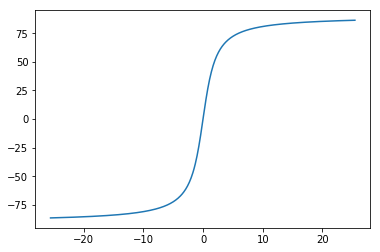

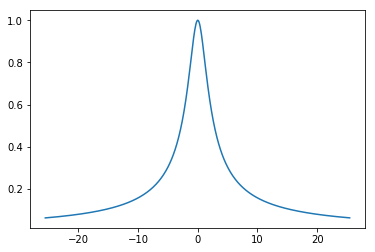

In [3]:
N = 512  #size of map is N x N pixels
tau_0 = 0.1        # Actual detector time constant, in seconds                  ###PERHAPS CHANGE THIS...LOOP
tau_1 = 0.7*tau_0   # Assumed (incorrect) detector time constant, in seconds     ###PERHAPS CHANGE THIS...LOOP

theta_side = 10. # degrees on a side
pixel_spacing = theta_side/(N-1)  # this is the distance between neighboring pixel centers, in degrees.
scan_rate = 1.0 # degrees per second on sky.                                     ###PERHAPS CHANGE THIS...LOOP

t_scan = theta_side/scan_rate # time to go all the way across the map, in seconds.
delta_t = t_scan/(N-1)  # time to cross from one pixel to the next.
samplerate = 1/delta_t  # Pretend data is sampled at center of each pixel.  In Hz.

# Set up frequency vector, and time constant filters in Fourier space. 
freqvec = np.fft.fftshift(np.fft.fftfreq(N,delta_t))
#filter_tau_0 = 1./np.sqrt(1. + (2*np.pi*np.abs(freqvec)*tau_0**2))     ###NEED PHASE AS WELL...e^i phi
#filter_tau_1 = 1./np.sqrt(1. + (2*np.pi*np.abs(freqvec)*tau_1**2))

######   NEW TAU FILTERS   #####

#filter_tau_0_transfunc = 1. / (1. + 1j*(tau_0*np.sqrt(2*np.pi*freqvec)))
filter_tau_0_transfunc = 1. / (1. + 1j*(2*np.pi*freqvec*tau_0))
#A = tau_0*np.sqrt(2*np.pi*freqvec)
A = -2*np.pi*freqvec*tau_0
tau_0_phase = np.arctan(-A) * (180/np.pi)
filter_tau_0 = np.abs(filter_tau_0_transfunc)

#filter_tau_1_transfunc = 1. / (1. + 1j*(tau_1*np.sqrt(2*np.pi*freqvec)))
filter_tau_1_transfunc = 1. / (1. + 1j*(2*np.pi*freqvec*tau_0))
#filter_tau_1 = np.abs(filter_tau_1_transfunc)
B = -2*np.pi*freqvec*tau_1
tau_1_phase = np.arctan(-B) * (180/np.pi)
filter_tau_1 = np.abs(filter_tau_1_transfunc)


plt.plot(freqvec, tau_0_phase)
print(samplerate)
plt.figure()
plt.plot(freqvec,filter_tau_0, label='True Time Const')
#plt.plot(freqvec, filter_tau_1, label='Estimated Time Const')
#plt.legend()

Next, we set up the initial map.  (Eventually this will be a noise map, or a cmb map, say)

In [19]:

theta_x,theta_y = np.meshgrid(np.linspace(-theta_side/2.,theta_side/2., N),np.linspace(-theta_side/2.,theta_side/2., N)) ## make a 2d array of x and y coordinates


Now we take that map and process it.  We can through row by row, convolve with tau_0, deconvolve with tau_1.

In [20]:
# Now, take that map and go through it row by row, taking the FT, filtering by the real time constant, deconvolving by the wrong time constant.
orig_map = 2*np.random.randn(N,N)     ###PERHAPS CHANGE THIS

############################ FOR A GAUSSIAN IMAGE INSTEAD OF NOISE
#x, y = np.meshgrid(np.linspace(-theta_side/2,theta_side/2,N), np.linspace(-theta_side/2,theta_side/2,N))
#d = np.sqrt(x*x+y*y)
#sigma, mu = 1.0, 0.0
#g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
#
#orig_map = g


processed_map = 0.0*orig_map
for row in range(N):
    rowvec = orig_map[row][:]
    rowfft = np.fft.fftshift(np.fft.fft(rowvec))    # Take FT of that row, shift it into nice freq order.
    filtered_rowfft = rowfft*filter_tau_0         # convolve it with the actual filter function.
    filtered_rowfft = filtered_rowfft/filter_tau_1         # De-convolve with the "wrong" filter function.
    filtered_rowvec = np.fft.ifft(np.fft.fftshift(filtered_rowfft))  # Inverse FT to get the processed map back in real map space.
    processed_map[row][:]=np.real(filtered_rowvec)   # put it back into a map.

C:\Users\Jared\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


Plot the input and output maps and the resulting processed map.

To do: Get these plotted with angular scales on the x and y axes.

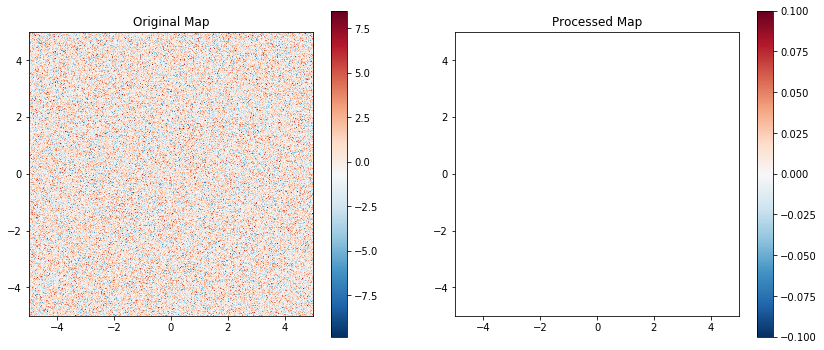

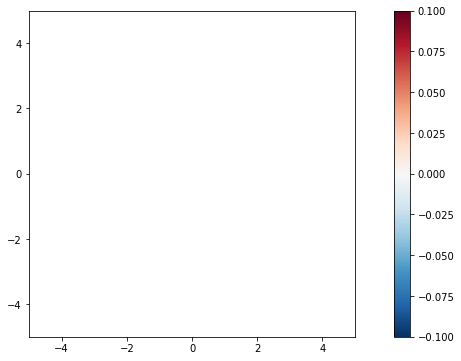

In [21]:
plt.rcParams['figure.figsize'] = [14, 6]
plt.subplot(121)
plt.imshow(orig_map, interpolation=None, origin='lower',cmap=cmap.RdBu_r,extent = [-theta_side/2, theta_side/2,-theta_side/2,theta_side/2])
plt.colorbar()
plt.title('Original Map')
plt.subplot(122)
plt.imshow(processed_map, interpolation=None, origin='lower',cmap=cmap.RdBu_r, extent = [-theta_side/2, theta_side/2,-theta_side/2,theta_side/2])
plt.colorbar()
plt.title('Processed Map')

plt.figure()
map_difference = orig_map - processed_map
plt.imshow(map_difference, interpolation=None, origin='lower',cmap=cmap.RdBu_r, extent = [-theta_side/2, theta_side/2,-theta_side/2,theta_side/2])
plt.colorbar()

Now calculate the 2D PSD's [=abs(FFT)] of each map.  Bin radially in kx and ky to get the power spectrum.

(ell = 1 has distance between peaks of 180deg;  nyquist has distance between peaks of one pixel spacing.  Use that to convert.)

9198.0


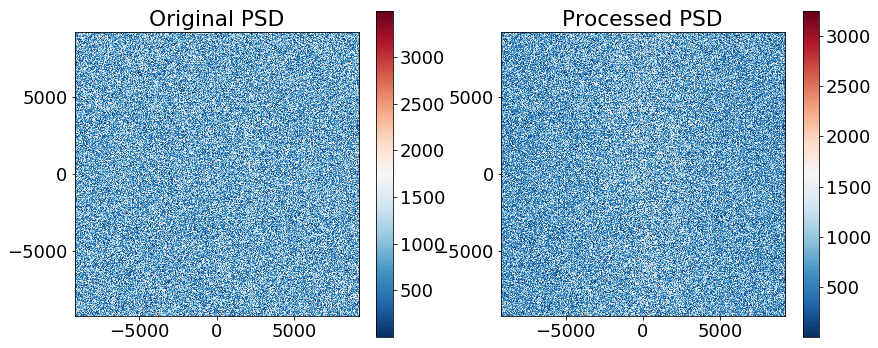

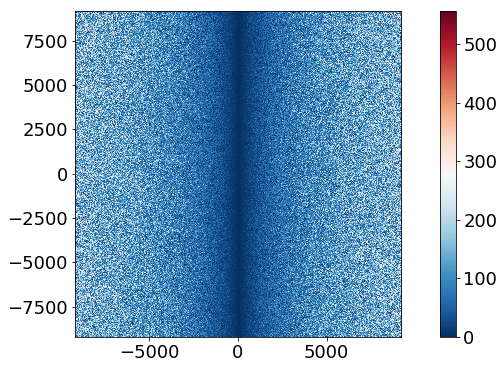

In [111]:
ellmax = 180/(pixel_spacing)  # ell=1 has hot/cold separated by 180deg, so at nyquist=ellmax.
print(ellmax)

orig_psd = np.fft.fftshift(np.abs(np.fft.fft2(orig_map)))
processed_psd = np.fft.fftshift(np.abs(np.fft.fft2(processed_map)))

plt.rcParams['figure.figsize'] = [14, 6]
plt.subplot(121)
plt.imshow(orig_psd, interpolation=None, origin='lower',cmap=cmap.RdBu_r, extent = [-ellmax, ellmax,-ellmax,ellmax])
plt.colorbar()
plt.title('Original PSD')
plt.subplot(122)
plt.imshow(processed_psd, interpolation=None, origin='lower',cmap=cmap.RdBu_r, extent = [-ellmax, ellmax,-ellmax,ellmax])
plt.colorbar()
plt.title('Processed PSD')

plt.figure()
difference_PSD = orig_psd - processed_psd
plt.imshow(difference_PSD, interpolation=None, origin='lower',cmap=cmap.RdBu_r, extent = [-ellmax, ellmax,-ellmax,ellmax])
plt.colorbar()

To do:  radially bin the PSD's above, and then plot the ratio as a function of ell.

In [58]:
pixel_spacing*60

1.1741682974559686

Now radially bin from ell=0 to ellmax, in bins of width ellmax/32.

In [120]:
# Try just making the square larger and only using the inside part from -ell to +ell in both x and y directions
##############################


# Create maps of ell_x and ell_y coordinates
ell_x,ell_y = np.meshgrid(np.linspace(-ellmax,ellmax, N),np.linspace(-ellmax,ellmax, N))   ###2x factors here
r = np.sqrt((ell_x)**2 + (ell_y)**2)   ###/2 factors here
r_max = r.max()
print(r_max)

# Set up the ell bins.
n_ellbins = 30 * 10   ###2x factors here
#n_ellbins = 300

ellbin_width = np.ceil(r_max/n_ellbins)  # an integer
ell_vec = (np.arange(0,n_ellbins)+0.5)*ellbin_width  # bin centers at the middle of the bin, hence the 0.5
ell_vec = ell_vec.astype(int)
C_ellvec_orig = np.zeros(n_ellbins)
C_ellvec_processed = np.zeros(n_ellbins)
C_ellvec_cnt = 0*C_ellvec_orig

ellbin = ((n_ellbins-1)*(r/r_max)).astype(int)
for row in range(N):
    for col in range(N):
        lb = ellbin[row][col]  # runs from 0 to n_ellbins-1
        C_ellvec_orig[lb] += orig_psd[row][col]
        C_ellvec_cnt[lb] += 1
        C_ellvec_processed[lb] += processed_psd[row][col]
        
Trans_vec = C_ellvec_processed/C_ellvec_orig

print(ellbin)

13007.93634670773
[[299 298 297 ... 297 298 299]
 [298 297 297 ... 297 297 298]
 [297 297 296 ... 296 297 297]
 ...
 [297 297 296 ... 296 297 297]
 [298 297 297 ... 297 297 298]
 [299 298 297 ... 297 298 299]]


[[299 298 297 ... 297 298 299]
 [298 297 297 ... 297 297 298]
 [297 297 296 ... 296 297 297]
 ...
 [297 297 296 ... 296 297 297]
 [298 297 297 ... 297 297 298]
 [299 298 297 ... 297 298 299]]


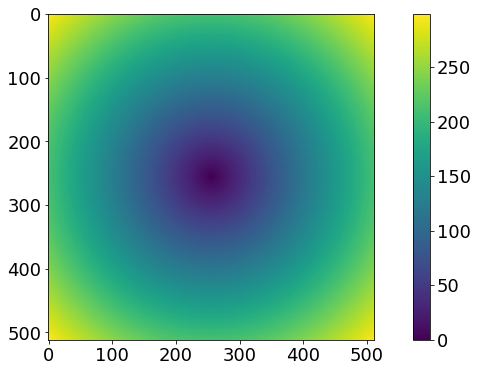

In [121]:
plt.imshow(ellbin, interpolation=None)
plt.colorbar()
ellbin.max()
print(ellbin)

13178
13007.93634670773


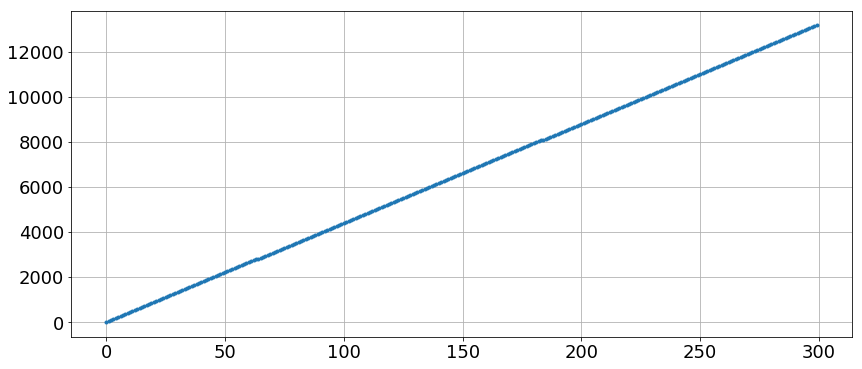

In [122]:
plt.plot(ell_vec,'.')
plt.grid()
print(ell_vec[-1])
print(r_max)

9198.0

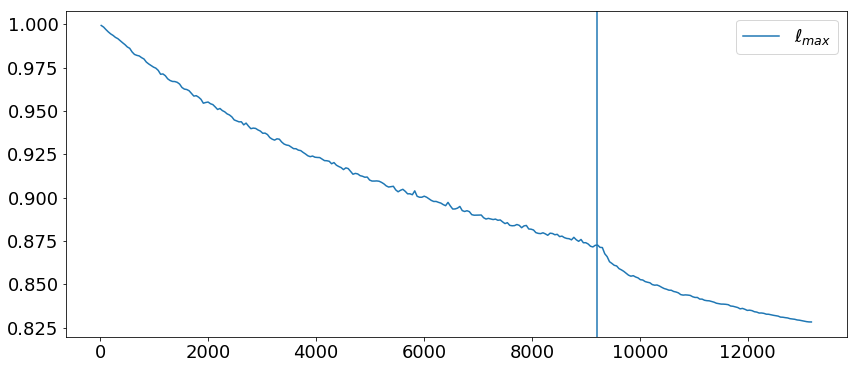

In [130]:
plt.plot(ell_vec,Trans_vec)
plt.axvline(ellmax, label='$\ell_{max}$')
plt.legend()
ellmax

#print(Trans_vec)

## LOOPING OVER DIFFERENT VARS - change both time constants and scan rate

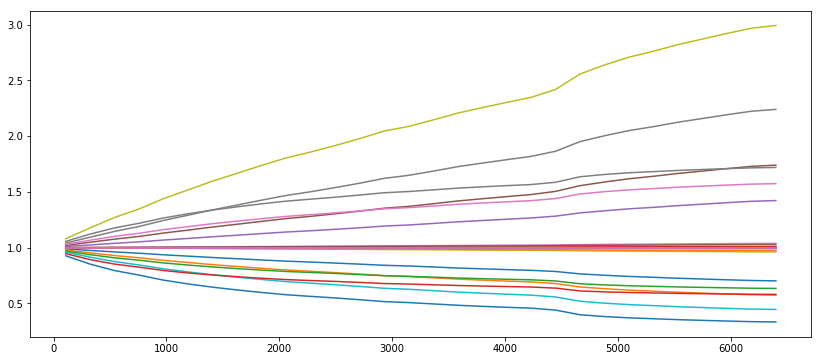

In [12]:


##################################
N = 256  #size of map is N x N pixels
theta_side = 10. # degrees on a side
pixel_spacing = theta_side/(N-1)  # this is the distance between neighboring pixel centers, in degrees.

theta_x,theta_y = np.meshgrid(np.linspace(-theta_side/2.,theta_side/2., N),np.linspace(-theta_side/2.,theta_side/2., N)) ## make a 2d array of x and y coordinates

orig_map = 2*np.random.randn(N,N)     ###PERHAPS CHANGE THIS
processed_map = 0.0*orig_map

ellmax = 180/(pixel_spacing)  # ell=1 has hot/cold separated by 180deg, so at nyquist=ellmax.

tau_scan = np.linspace(0.001, 0.1, 3)
scan_rate_range = np.linspace(0.1, 10, 3)

for i in range(len(tau_scan)):
    tau_0_scan = tau_scan[i]
    
    for j in range(len(tau_scan)):
        tau_1_scan = tau_scan[j]
        
        for k in range(len(scan_rate_range)):
            scan_rate_scan = scan_rate_range[k]
            
            t_scan = theta_side/scan_rate_scan # time to go all the way across the map, in seconds.
            delta_t = t_scan/(N-1)  # time to cross from one pixel to the next.
            samplerate = 1/delta_t  # Pretend data is sampled at center of each pixel.  In Hz.
            freqvec = np.fft.fftshift(np.fft.fftfreq(N,delta_t))
            filter_tau_0 = 1./np.sqrt(1. + (2*np.pi*np.abs(freqvec)*tau_0_scan**2))
            filter_tau_1 = 1./np.sqrt(1. + (2*np.pi*np.abs(freqvec)*tau_1_scan**2))
            
            for row in range(N):
                rowvec = orig_map[row][:]
                rowfft = np.fft.fftshift(np.fft.fft(rowvec))    # Take FT of that row, shift it into nice freq order.
                filtered_rowfft = rowfft*filter_tau_0         # convolve it with the actual filter function.
                filtered_rowfft = filtered_rowfft/filter_tau_1         # De-convolve with the "wrong" filter function.
                filtered_rowvec = np.fft.ifft(np.fft.fftshift(filtered_rowfft))  # Inverse FT to get the processed map back in real map space.
                processed_map[row][:]=np.real(filtered_rowvec)   # put it back into a map.
                
            orig_psd = np.fft.fftshift(np.abs(np.fft.fft2(orig_map)))
            processed_psd = np.fft.fftshift(np.abs(np.fft.fft2(processed_map)))
            
            pixel_spacing*60
            
            ell_x,ell_y = np.meshgrid(np.linspace(-ellmax,ellmax, N),np.linspace(-ellmax,ellmax, N))
            r = np.sqrt(ell_x**2 + ell_y**2)
            r_max = r.max()
            
            # Set up the ell bins.
            n_ellbins = 30
            #n_ellbins = 300
            
            ellbin_width = np.ceil(r_max/n_ellbins)  # an integer
            ell_vec = (np.arange(0,n_ellbins)+0.5)*ellbin_width  # bin centers at the middle of the bin, hence the 0.5
            ell_vec = ell_vec.astype(int)
            C_ellvec_orig = np.zeros(n_ellbins)
            C_ellvec_processed = np.zeros(n_ellbins)
            C_ellvec_cnt = 0*C_ellvec_orig
            
            ellbin = ((n_ellbins-1)*(r/r_max)).astype(int)
            for row in range(N):
                for col in range(N):
                    lb = ellbin[row][col]  # runs from 0 to n_ellbins-1
                    C_ellvec_orig[lb] += orig_psd[row][col]
                    C_ellvec_cnt[lb] += 1
                    C_ellvec_processed[lb] += processed_psd[row][col]
                    
            Trans_vec = C_ellvec_processed/C_ellvec_orig
            
            #plt.figure()
            plt.plot(ell_vec,Trans_vec)
            
            
            
            
            

                        
                       
    
    